## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F310; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F310; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F310; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

In [40]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}              
</style>

In [2]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from descartes import PolygonPatch

from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.linear_model import HuberRegressor, TheilSenRegressor, RANSACRegressor

In [3]:
def regression(regressor, x_train, x_test, y_train):
    reg = regressor
    reg.fit(x_train, y_train)
    
    y_train_reg = reg.predict(x_train)
    y_test_reg = reg.predict(x_test)
    
    return y_train_reg, y_test_reg

def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))

## &#x1F310; &nbsp; Load and Preprocess the Data

In [4]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [5]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(41,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))    

NaN count =  0


In [8]:
# Merge two datasets
d5_shsat_2016 = d5_shsat[['DBN','Number of students who registered for the SHSAT',
                          'Number of students who took the SHSAT']][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')
d5_shsat_2016.shape

(21, 144)

## &#x1F310; &nbsp; Split the Data for Regressor Training

#### The first set of features

In [9]:
# data = school_explorer, features = numeric veriables, targets = Average Math Proficiency
features = school_explorer[numeric_list].values
targets = school_explorer['Average Math Proficiency'].values

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((1017, 138), (255, 138), (1017,), (255,))

In [10]:
# data = school_explorer, features = numeric veriables, targets = Average ELA Proficiency
features = school_explorer[numeric_list].values
targets = school_explorer['Average ELA Proficiency'].values

X_train2, X_test2, y_train2, y_test2 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((1017, 138), (255, 138), (1017,), (255,))

#### The second set of features

In [11]:
# data = school_explorer, 
features_list = percent_list+category_list+['School Income Estimate','Economic Need Index'] 
# targets = Average Math Proficiency
features = school_explorer[features_list].values
targets = school_explorer['Average Math Proficiency'].values

X_train3, X_test3, y_train3, y_test3 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((1017, 27), (255, 27), (1017,), (255,))

In [12]:
# data = school_explorer, 
features_list = percent_list+category_list+['School Income Estimate','Economic Need Index'] 
# targets = Average ELA Proficiency
features = school_explorer[features_list].values
targets = school_explorer['Average ELA Proficiency'].values

X_train4, X_test4, y_train4, y_test4 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((1017, 27), (255, 27), (1017,), (255,))

## &#x1F310; &nbsp; Fit the Regressors

#### The first set of features
The predictions are based on the data about the financial situation, social environment, ethnic composition and test results of each grade.

In [13]:
y_train_gbr1, y_test_gbr1 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=138), 
           X_train1, X_test1, y_train1)

scores('Gradient Boosting Regressor \nAverage Math Proficiency', 
       y_train1, y_test1, y_train_gbr1, y_test_gbr1)

_______________________________________
Gradient Boosting Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9815852114203323
EV score. Test:  0.8923990326814502
---------
R2 score. Train:  0.9815852114203323
R2 score. Test:  0.8923848124214963
---------
MSE score. Train:  0.004013459926885169
MSE score. Test:  0.022974591032430835
---------
MAE score. Train:  0.048859917349381825
MAE score. Test:  0.11559156464689388
---------
MdAE score. Train:  0.0398670038457154
MdAE score. Test:  0.09066553740670713


In [14]:
y_train_rfr1, y_test_rfr1 = \
regression(RandomForestRegressor(n_estimators=138), 
           X_train1, X_test1, y_train1)

scores('Random Forest Regressor \nAverage Math Proficiency', 
       y_train1, y_test1, y_train_rfr1, y_test_rfr1)

_______________________________________
Random Forest Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9779665333198753
EV score. Test:  0.8803451697625796
---------
R2 score. Train:  0.9779652281846473
R2 score. Test:  0.8803392917614553
---------
MSE score. Train:  0.0048024267721770725
MSE score. Test:  0.025546169609434736
---------
MAE score. Train:  0.049871986020264096
MAE score. Test:  0.12373267737046525
---------
MdAE score. Train:  0.038152173913037046
MdAE score. Test:  0.10036231884057845


In [15]:
y_train_gbr2, y_test_gbr2 = \
regression(GradientBoostingRegressor(max_depth=5, n_estimators=276), 
           X_train2, X_test2, y_train2)

scores('Gradient Boosting Regressor \nAverage ELA Proficiency', 
       y_train2, y_test2, y_train_gbr2, y_test_gbr2)

_______________________________________
Gradient Boosting Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.9991525930620759
EV score. Test:  0.8689747962201941
---------
R2 score. Train:  0.9991525930620759
R2 score. Test:  0.8689103860213879
---------
MSE score. Train:  0.00010655639219100782
MSE score. Test:  0.01882739273539521
---------
MAE score. Train:  0.007692157878821912
MAE score. Test:  0.10066601515609798
---------
MdAE score. Train:  0.0059483144717873415
MdAE score. Test:  0.07381329727130481


In [24]:
y_train_rfr2, y_test_rfr2 = \
regression(RandomForestRegressor(n_estimators=276), 
           X_train2, X_test2, y_train2)

scores('Random Forest Regressor \nAverage ELA Proficiency', 
       y_train1, y_test2, y_train_rfr2, y_test_rfr2)

_______________________________________
Random Forest Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.8225560588772535
EV score. Test:  0.8464615627645198
---------
R2 score. Train:  0.7356160286623005
R2 score. Test:  0.8464308012128067
---------
MSE score. Train:  0.057621865691480055
MSE score. Test:  0.022055962557782777
---------
MAE score. Train:  0.18627023718761732
MAE score. Test:  0.10757758951406639
---------
MdAE score. Train:  0.15022946859904174
MdAE score. Test:  0.08202657004830582


#### The second set of features
The predictions are based on the data about the financial situation, social environment, ethnic composition and geoposition.

In [17]:
y_train_gbr3, y_test_gbr3 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=81), 
           X_train3, X_test3, y_train3)

scores('Gradient Boosting Regressor \nAverage Math Proficiency', 
       y_train3, y_test3, y_train_gbr3, y_test_gbr3)

_______________________________________
Gradient Boosting Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.950148691725299
EV score. Test:  0.8615561210152158
---------
R2 score. Train:  0.950148691725299
R2 score. Test:  0.8611024248243095
---------
MSE score. Train:  0.010864975571004975
MSE score. Test:  0.029653016984521195
---------
MAE score. Train:  0.08038728735945014
MAE score. Test:  0.1300863419512142
---------
MdAE score. Train:  0.06329352049169534
MdAE score. Test:  0.09617163621473201


In [18]:
y_train_rfr3, y_test_rfr3 = \
regression(RandomForestRegressor(n_estimators=81), 
           X_train3, X_test3, y_train3)

scores('Random Forest Regressor \nAverage Math Proficiency', 
       y_train3, y_test3, y_train_rfr3, y_test_rfr3)

_______________________________________
Random Forest Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9728864666024276
EV score. Test:  0.8443891373243838
---------
R2 score. Train:  0.9728840461415703
R2 score. Test:  0.8443749726129268
---------
MSE score. Train:  0.005909858466158869
MSE score. Test:  0.03322413349900667
---------
MAE score. Train:  0.05421048957840174
MAE score. Test:  0.13903312353748085
---------
MdAE score. Train:  0.03913580246913595
MdAE score. Test:  0.1127777777777772


In [19]:
y_train_gbr4, y_test_gbr4 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=108), 
           X_train4, X_test4, y_train4)

scores('Gradient Boosting Regressor \nAverage ELA Proficiency', 
       y_train4, y_test4, y_train_gbr4, y_test_gbr4)

_______________________________________
Gradient Boosting Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.959742508489626
EV score. Test:  0.8541044480840445
---------
R2 score. Train:  0.959742508489626
R2 score. Test:  0.8540398499047682
---------
MSE score. Train:  0.005062140586805272
MSE score. Test:  0.020963133433351308
---------
MAE score. Train:  0.055913030278784755
MAE score. Test:  0.1048379809011442
---------
MdAE score. Train:  0.04733115290358869
MdAE score. Test:  0.08598829301948285


In [20]:
y_train_rfr4, y_test_rfr4 = \
regression(RandomForestRegressor(n_estimators=108), 
           X_train4, X_test4, y_train4)

scores('Random Forest Regressor \nAverage ELA Proficiency', 
       y_train4, y_test4, y_train_rfr4, y_test_rfr4)

_______________________________________
Random Forest Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.9738846222774414
EV score. Test:  0.8258316366925703
---------
R2 score. Train:  0.9738844887031807
R2 score. Test:  0.8256659164060335
---------
MSE score. Train:  0.0032838705225022237
MSE score. Test:  0.02503826321072501
---------
MAE score. Train:  0.04098157935467432
MAE score. Test:  0.11022064572742685
---------
MdAE score. Train:  0.03023148148148236
MdAE score. Test:  0.07839506172839439


## &#x1F310; &nbsp; Display Predictions

#### The first set of features

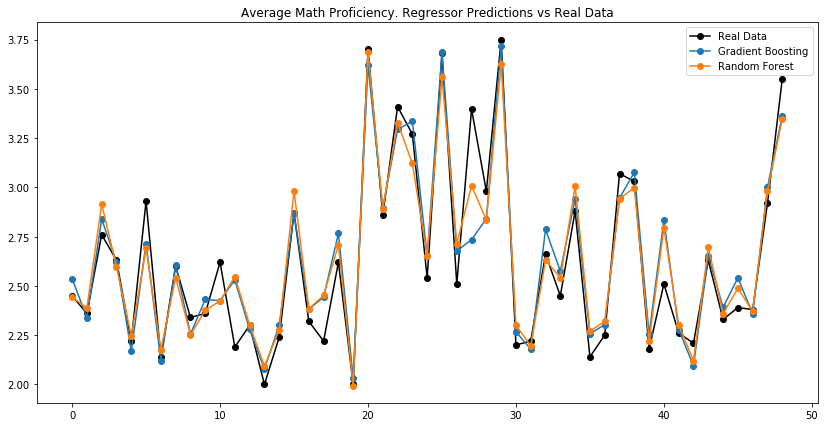

In [25]:
plt.figure(figsize = (14, 7))

plt.plot(y_test1[1:50], '-o', color = 'black', label='Real Data')
plt.plot(y_test_gbr1[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr1[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average Math Proficiency. Regressor Predictions vs Real Data");

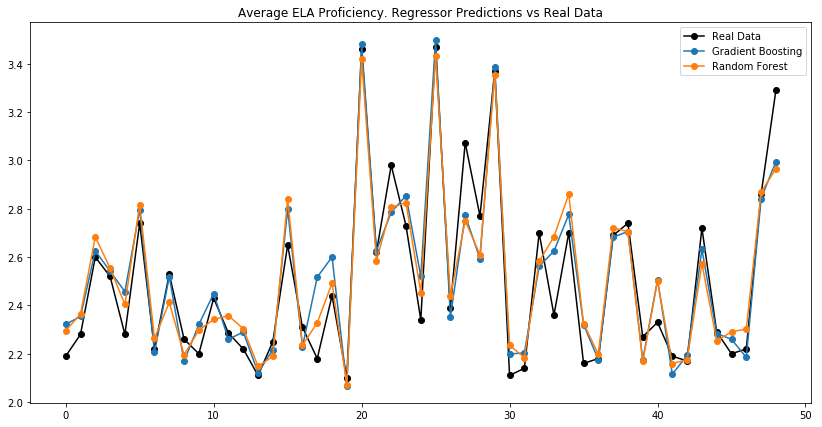

In [26]:
plt.figure(figsize = (14, 7))

plt.plot(y_test2[1:50], '-o', color='black', label='Real Data')
plt.plot(y_test_gbr2[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr2[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average ELA Proficiency. Regressor Predictions vs Real Data");

The numerical variables in the presented database about the financial situation, social environment, ethnic composition and test results of each grade  make it possible to predict the indicators of learning outcomes `Average Math Proficiency`, `Average ELA Proficiency` quite well (0.84-0.89 is a really high level for R2).

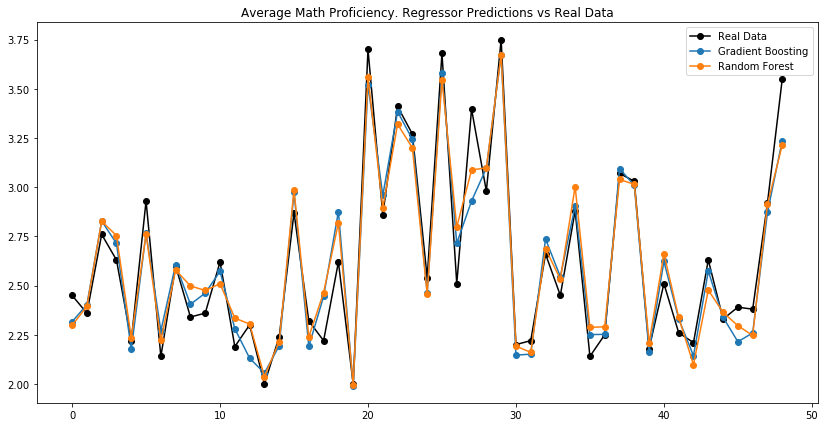

In [27]:
plt.figure(figsize = (14, 7))

plt.plot(y_test3[1:50], '-o', color = 'black', label='Real Data')
plt.plot(y_test_gbr3[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr3[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average Math Proficiency. Regressor Predictions vs Real Data");

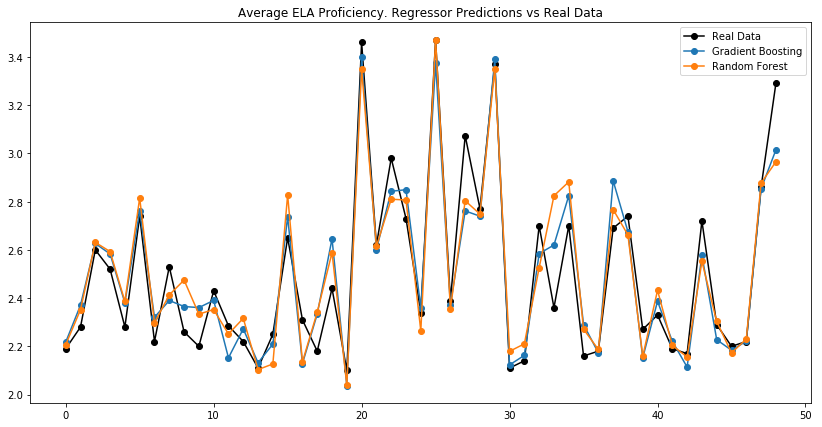

In [28]:
plt.figure(figsize = (14, 7))

plt.plot(y_test4[1:50], '-o', color = 'black', label='Real Data')
plt.plot(y_test_gbr4[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr4[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average ELA Proficiency. Regressor Predictions vs Real Data");

The numerical variables in the presented database about the financial situation, social environment, ethnic composition and geoposition make predictions the indicators of learning outcomes `Average Math Proficiency`, `Average ELA Proficiency`  a little bit worse  (0.82-0.86 for R2).

## &#x1F310; &nbsp; Features' Importance

#### The first set of features

In [30]:
df_importance1 = pd.DataFrame(columns=range(138))

df_importance1.loc[0] = GradientBoostingRegressor(max_depth=4, n_estimators=138)\
.fit(X_train1, y_train1).feature_importances_
df_importance1.loc[1] = RandomForestRegressor(n_estimators=138)\
.fit(X_train1, y_train1).feature_importances_
df_importance1.loc[2] = GradientBoostingRegressor(max_depth=5, n_estimators=276)\
.fit(X_train2, y_train2).feature_importances_
df_importance1.loc[3]= RandomForestRegressor(n_estimators=276)\
.fit(X_train2, y_train2).feature_importances_

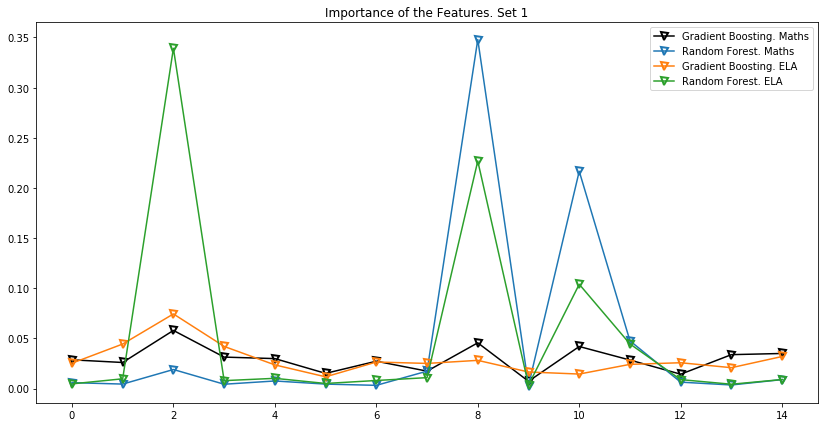

In [31]:
plt.figure(figsize=(14,7))
n=15

plt.plot(df_importance1.loc[0][:n], '-v', color = 'black', label='Gradient Boosting. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance1.loc[1][:n], '-v', label='Random Forest. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance1.loc[2][:n], '-v', label='Gradient Boosting. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance1.loc[3][:n], '-v', label='Random Forest. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Importance of the Features. Set 1");

In [32]:
index_gbr_math1 = list(df_importance1.loc[0,].sort_values(ascending=False)[:20].index)
index_rfr_math1 = list(df_importance1.loc[1,].sort_values(ascending=False)[:20].index)
index_gbr_ela1 = list(df_importance1.loc[2,].sort_values(ascending=False)[:20].index)
index_rfr_ela1 = list(df_importance1.loc[3,].sort_values(ascending=False)[:20].index)
features1 = school_explorer[numeric_list]

The most influential indicators for the variable `Average Math Proficiency`:

In [33]:
for el in list(features1.iloc[:,index_gbr_math1].columns):
    if el in list(features1.iloc[:,index_rfr_math1].columns):
        print(el)

Economic Need Index
Percent Black / Hispanic
Student Attendance Rate
Supportive Environment %
Grade 5 Math 4s - All Students
Percent ELL
Latitude
Percent of Students Chronically Absent
Longitude
Grade 8 Math - All Students Tested
Strong Family-Community Ties %
Grade 4 Math 4s - All Students
Percent Hispanic


The most influential indicators for the variable `Average ELA Proficiency`:

In [34]:
for el in list(features1.iloc[:,index_gbr_ela1].columns):
    if el in list(features1.iloc[:,index_rfr_ela1].columns):
        print(el)

Economic Need Index
Longitude
School Income Estimate
Supportive Environment %
Percent Black / Hispanic
Strong Family-Community Ties %
Percent Black
Rigorous Instruction %
Percent Hispanic
Percent of Students Chronically Absent
Percent ELL
Grade 3 Math 4s - All Students
Grade 5 ELA 4s - All Students
Grade 4 ELA 4s - All Students


#### The second set of features

In [35]:
df_importance2 = pd.DataFrame(columns=range(27))

df_importance2.loc[0] = GradientBoostingRegressor(max_depth=4, n_estimators=81)\
.fit(X_train3, y_train3).feature_importances_
df_importance2.loc[1] = RandomForestRegressor(n_estimators=81)\
.fit(X_train3, y_train3).feature_importances_
df_importance2.loc[2] = GradientBoostingRegressor(max_depth=4, n_estimators=108)\
.fit(X_train4, y_train4).feature_importances_
df_importance2.loc[3]= RandomForestRegressor(n_estimators=54)\
.fit(X_train4, y_train4).feature_importances_

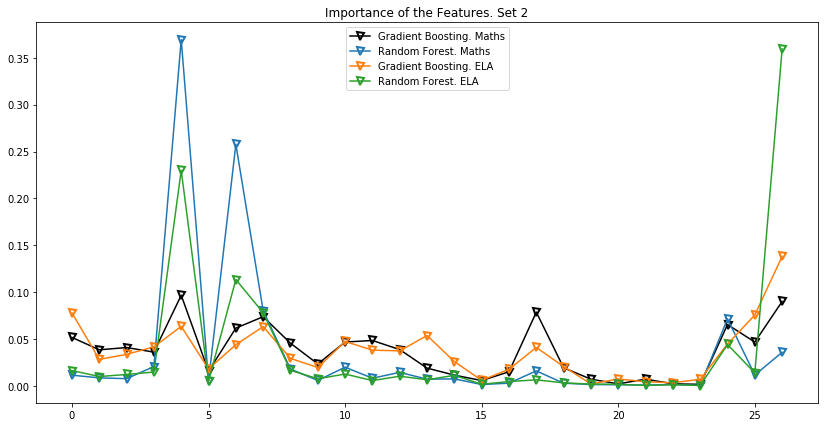

In [36]:
plt.figure(figsize=(14,7))
n=27

plt.plot(df_importance2.loc[0][:n], '-v', color = 'black', label='Gradient Boosting. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance2.loc[1][:n], '-v', label='Random Forest. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance2.loc[2][:n], '-v', label='Gradient Boosting. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance2.loc[3][:n], '-v', label='Random Forest. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Importance of the Features. Set 2");

In [37]:
index_gbr_math2 = list(df_importance2.loc[0,].sort_values(ascending=False)[:15].index)
index_rfr_math2 = list(df_importance2.loc[1,].sort_values(ascending=False)[:15].index)
index_gbr_ela2 = list(df_importance2.loc[2,].sort_values(ascending=False)[:15].index)
index_rfr_ela2 = list(df_importance2.loc[3,].sort_values(ascending=False)[:15].index)
features2 = school_explorer[features_list]

The most influential indicators for the variable `Average Math Proficiency`:

In [38]:
for el in list(features2.iloc[:,index_gbr_math2].columns):
    if el in list(features2.iloc[:,index_rfr_math2].columns):
        print(el)

Percent Black / Hispanic
Economic Need Index
Grades
Percent of Students Chronically Absent
Student Achievement Rating
Student Attendance Rate
Percent ELL
Effective School Leadership %
Supportive Environment %
School Income Estimate
Rigorous Instruction %
Percent Black
Strong Family-Community Ties %
Percent Asian
Percent Hispanic


The most influential indicators for the variable `Average ELA Proficiency`:

In [39]:
for el in list(features2.iloc[:,index_gbr_ela2].columns):
    if el in list(features2.iloc[:,index_rfr_ela2].columns):
        print(el)

Economic Need Index
Percent ELL
School Income Estimate
Percent Black / Hispanic
Percent of Students Chronically Absent
Supportive Environment %
Student Achievement Rating
Student Attendance Rate
Percent Hispanic
Strong Family-Community Ties %
Percent Black
Rigorous Instruction %


In general, we can make a list of the most influential indicators for the educational results.

- Financial: `Economic Need Index`
- Social: `Supportive Environment`
- Organizational: `Student Attendance Rate`
- Linguistical: `Percent ELL`
- Ethnical: `Percent Black / Hispanic`